In [1]:
import numpy as np
import tensorflow as tf
import os
import copy
from math import pi
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from pandas import DataFrame as DF
from models import AP_ResNet, ResNet, VGG_branch, ResNetLSTM, ConvLSTM, build_transformer_model

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from classifier import preprocessing as prep
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

2022-08-16 03:59:43.768216: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class_names = ['asphalt','bicycle','block','floor','ground']
data_len = 414
use_len = 100
# bound = data_len - use_len

In [3]:
def heatmap(matrix,title):
    df=DF(matrix, index = class_names, columns = class_names)
    plt.figure(figsize=(10,10))
    sns.heatmap(df, annot=True)
    plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Prediction",position = (0.5,1.0+0.05))
    plt.ylabel("Object")
    plt.title(title)

In [4]:
label2idx_Dict = {
                'asphalt' : 0,
                'bicycle' : 1,
                'block' : 2,
                'floor' : 3,
                'ground' : 4,
            }

idx2label_Dict = {
    0 : 'asphalt',
    1 : 'bicycle',
    2 : 'block',
    3 : 'floor',
    4 : 'ground',
}

In [5]:
dir_path = './road_data'
def readNpy(dir_path):
    class_num = len(idx2label_Dict)

    Asphalt = list()
    Bicycle = list()
    Block = list()
    Floor = list()
    Ground = list()
    Asphalt = np.array(Asphalt)
    Bicycle = np.array(Bicycle)
    Block = np.array(Block)
    Floor = np.array(Floor)
    Ground = np.array(Ground)
    

    for dir in os.listdir(dir_path):
        d_path = os.path.join(dir_path, dir)
        file_list = os.listdir(d_path)
        for file in file_list:
            file_path = os.path.join(d_path, file)
            if dir == idx2label_Dict[0] :
                if len(Asphalt) == 0:
                    Asphalt = np.load(file_path, allow_pickle=True)
                else :
                    Asphalt = np.append(Asphalt, np.load(file_path), axis = 0)
            elif dir == idx2label_Dict[1]:
                if len(Bicycle) == 0:
                    Bicycle = np.load(file_path, allow_pickle=True)
                else :
                    Bicycle = np.append(Bicycle, np.load(file_path), axis = 0)
            elif dir == idx2label_Dict[2]:
                if len(Block) == 0:
                    Block = np.load(file_path, allow_pickle=True)
                else:
                    Block = np.append(Block, np.load(file_path), axis = 0)
            elif dir == idx2label_Dict[3]:
                if len(Floor) == 0:
                    Floor = np.load(file_path, allow_pickle=True)
                else:
                    Floor = np.append(Floor, np.load(file_path), axis = 0)
            elif dir == idx2label_Dict[4]:
                if len(Ground) == 0:
                    Ground = np.load(file_path, allow_pickle=True)
                else:
                    Ground = np.append(Ground, np.load(file_path), axis = 0)

    # bound = Asphalt.shape[1]
    # global bound
    global data_len
    global use_len
    Ground_label = np.full((Ground.shape[0], class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['ground']])
    Asphalt_label = np.full((Asphalt.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['asphalt']])
    Bicycle_label = np.full((Bicycle.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['bicycle']])
    Block_label = np.full((Block.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['block']])
    Floor_label = np.full((Floor.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['floor']])

    Ground = np.concatenate((Ground, Ground_label), axis=1)
    Asphalt = np.concatenate((Asphalt, Asphalt_label), axis=1)
    Bicycle = np.concatenate((Bicycle, Bicycle_label), axis=1)
    Block = np.concatenate((Block, Block_label), axis=1)
    Floor = np.concatenate((Floor, Floor_label), axis=1)
    
    array = Asphalt
    array = np.append(array, Bicycle, axis = 0)
    array = np.append(array, Block, axis = 0)
    array = np.append(array, Floor, axis = 0)
    array = np.append(array, Ground, axis = 0)
    s = np.arange(array.shape[0])
    np.random.shuffle(s)
    array_s = array[s]

    X = array_s[:,:use_len]
    Y = np.real(array_s[:,data_len:])
    return copy.deepcopy(X), copy.deepcopy(Y)

X, y = readNpy(dir_path)

In [6]:
def seperater(arr):
    global maximum
    pre_data = arr
    amp = np.abs(pre_data)
    amp = amp / maximum
    phs = np.angle(pre_data)
    # phs = (phs - (- pi)) / (pi - (- pi))
    sin = np.sin(phs)
    sin = (sin + 1) / 2
    seperated_data = np.stack((amp.T,sin.T), axis=0)
    seperated_data = np.expand_dims(seperated_data, axis=0)
    return np.array(seperated_data)

In [7]:
def dataSeperator(arr):
    temp = copy.deepcopy(seperater(arr[0]))
    for i in range(1, len(arr)):
        temp = np.concatenate((temp, seperater(arr[i])), axis=0)
    return temp

In [8]:
maximum = np.max(np.abs(X))

In [9]:
Split_X = dataSeperator(X)

In [10]:
checkpoint_filepath = 'road_detection_lstm'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = './model/' + checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    save_weigths_only = False,
)
log_dir = './logs/fit/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [11]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data[0])-seq_length-1):
        x = data[0][:][i:(i+seq_length)]
        y = data[1][i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
seq_length = 10
X, Y = create_sequences((Split_X, y), seq_length = seq_length)

In [13]:
print(X.shape, Y.shape)

(2389, 10, 2, 100) (2389, 5)


In [14]:
def train(
    model, X, Y,
    test_X, test_Y, 
    batch_size = 64, history_dict = None
    ):
    Epoch = 1
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + 'Resnet_LSTM',
        monitor='val_accuracy',
        mode='max',
        save_best_only = True,
        save_weigths_only = False,
    )
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = ['accuracy', 'categorical_crossentropy'])
    history = model.fit(X, Y,  batch_size = batch_size, epochs = Epoch,
                callbacks = callback, 
                validation_data = (test_X, test_Y),
                # validation_split = 0.3
                )
    return history

In [15]:
X = X[:, :, 0, :]

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [17]:
input_shape = X_train.shape[1:]
model = build_transformer_model(
    input_shape,
    head_size=256,
    num_heads=32,
    ff_dim=64,
    num_transformer_blocks=4,
    mlp_units=[2048],
    mlp_dropout=0.8,
    dropout=0.8,
)

2022-08-16 03:59:50.293414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 03:59:50.844526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22304 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 100)]    0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 100)     200         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 100)     3301476     ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

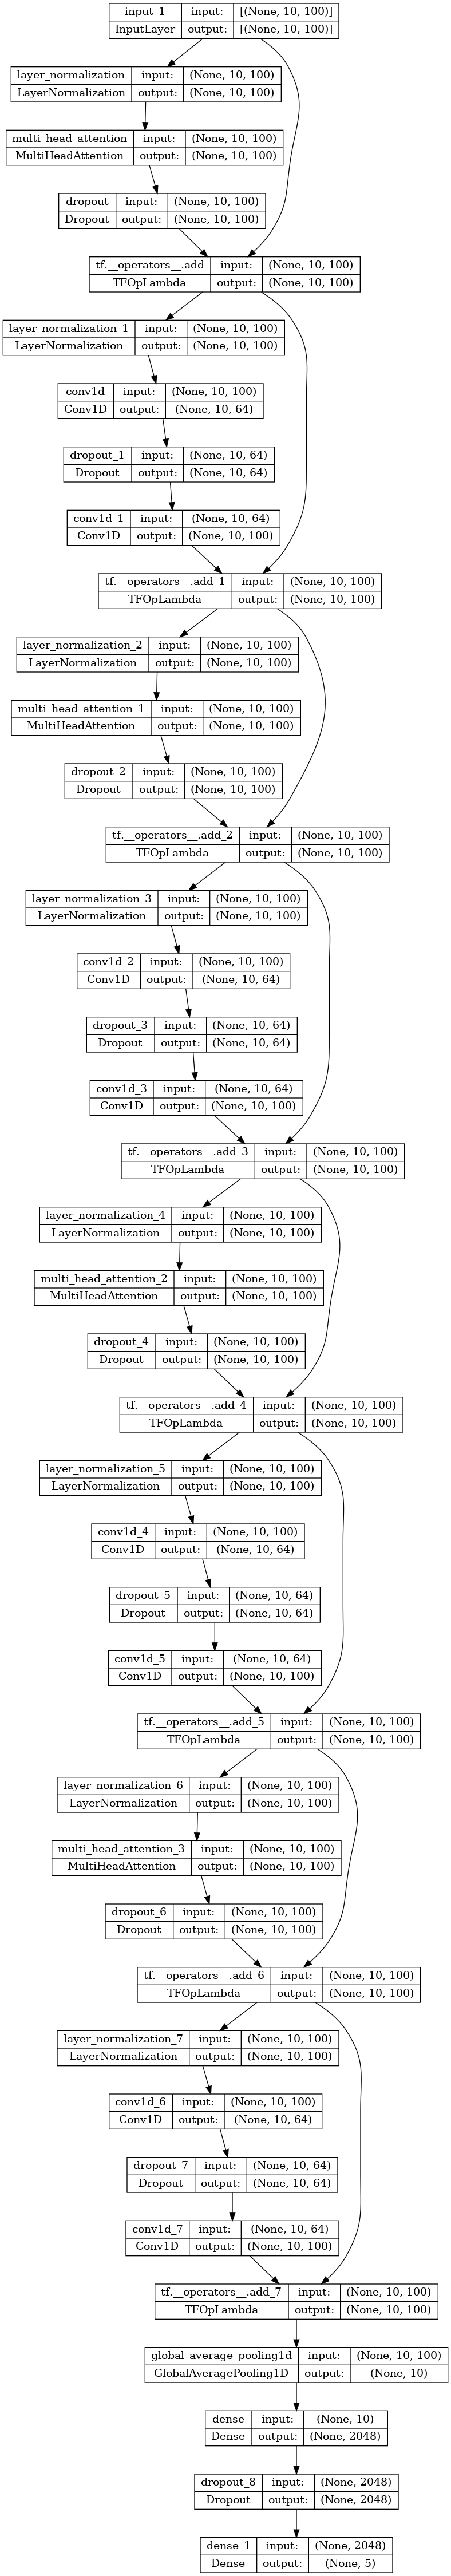

In [18]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer = optimizer , loss = loss, 
            metrics = ['accuracy', 'categorical_crossentropy'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [19]:
history = model.fit(
    X_train,
    Y_train,
    # validation_split=0.2,
    epochs=2000,
    batch_size=64,
    # callbacks=callbacks,
    validation_data=(X_test,Y_test),
)

Epoch 1/2000


2022-08-16 04:28:17.932637: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-16 04:28:18.108120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301


27/27 [==============================] - 8s 65ms/step - loss: 1.6081 - accuracy: 0.2075 - categorical_crossentropy: 1.6081 - val_loss: 1.5813 - val_accuracy: 0.2287 - val_categorical_crossentropy: 1.5813
Epoch 2/2000
27/27 [==============================] - 1s 41ms/step - loss: 1.5796 - accuracy: 0.2512 - categorical_crossentropy: 1.5796 - val_loss: 1.6011 - val_accuracy: 0.2287 - val_categorical_crossentropy: 1.6011
Epoch 3/2000
27/27 [==============================] - 1s 42ms/step - loss: 1.5749 - accuracy: 0.2482 - categorical_crossentropy: 1.5749 - val_loss: 1.5716 - val_accuracy: 0.2287 - val_categorical_crossentropy: 1.5716
Epoch 4/2000
27/27 [==============================] - 1s 41ms/step - loss: 1.5725 - accuracy: 0.2482 - categorical_crossentropy: 1.5725 - val_loss: 1.6094 - val_accuracy: 0.2287 - val_categorical_crossentropy: 1.6094
Epoch 5/2000
27/27 [==============================] - 1s 39ms/step - loss: 1.5723 - accuracy: 0.2356 - categorical_crossentropy: 1.5723 - val_los

In [18]:
test_len = 100
train_X, test_X = X[:-100], X[-100:]
train_Y, test_Y = Y[:-100], Y[-100:]

In [19]:
print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(2289, 10, 414) (100, 10, 414) (2289, 5) (100, 5)


In [20]:
cl_model = ConvLSTM()
history = train(cl_model, train_X, train_Y, test_X, test_Y, batch_size = 0 )

2022-08-12 14:35:55.998215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 14:35:56.495681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22304 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6
2022-08-12 14:36:04.429669: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2022-08-12 14:36:05.965889: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


72/72 [==============================] - ETA: 0s - loss: 4.3048 - accuracy: 0.2329 - categorical_crossentropy: 4.3048WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.regularization.dropout.Dropout object at 0x7f4b64091c40>, because it is not built.
INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets
72/72 [==============================] - 37s 388ms/step - loss: 4.3048 - accuracy: 0.2329 - categorical_crossentropy: 4.3048 - val_loss: 1.6184 - val_accuracy: 0.1900 - val_categorical_crossentropy: 1.6184


In [21]:
history.history['val_accuracy']

[0.1899999976158142]

In [22]:
dropout_rate = dict()
for i in range(8):
    dropout = i / 10
    print(dropout)
    model_amp = ResNet(dropout = dropout)
    history = train(model_amp, Split_X, y)
    dropout_rate[dropout] = history

0.0


TypeError: train() missing 2 required positional arguments: 'test_X' and 'test_Y'

In [ ]:
print(dropout_rate[0.0].history.keys())

In [ ]:
print(np.max(dropout_rate[0.0].history['val_accuracy']))
print(np.max(dropout_rate[0.1].history['val_accuracy']))
print(np.max(dropout_rate[0.2].history['val_accuracy']))
print(np.max(dropout_rate[0.3].history['val_accuracy']))
print(np.max(dropout_rate[0.4].history['val_accuracy']))
print(np.max(dropout_rate[0.5].history['val_accuracy']))

In [ ]:
model = ResNetLSTM()
history = train(model, X, Y)

In [ ]:
model.summary()